In [612]:
import pandas as pd
import numpy as np

## Load Data

In [613]:
raw = []

In [614]:
from os import listdir
from os.path import isfile, join, isdir

train_foldername = 'authorship-verification/training'
train_folders = [f for f in listdir(train_foldername)]
for f in sorted(train_folders):
    file_dir = train_foldername+'/'+f
    if isdir(file_dir):
        file_path = train_foldername+'/'+f

        unknown = pd.read_csv(file_path+'/'+'unknown.txt', sep="delimiter", header=None, engine='python')[0].str.cat(sep=' ')
        known = pd.read_csv(file_path+'/'+'known01.txt', sep="delimiter", header=None, engine='python')[0].str.cat(sep=' ')

        df = {
            'id': f,
            'unknown' : unknown.replace('_', ''),
            'known' : known.replace('_', '')
        }
        raw.append(df)

In [615]:
truth = pd.read_csv(train_foldername+'/'+'truth.txt', sep=" ", header=None, engine='python', names=['id', 'truth'])
truth

,id,truth
0,EN001,Y
1,EN002,N
2,EN003,N
3,EN004,N
4,EN005,Y
...,...,...
95,EN096,N
96,EN097,Y
97,EN098,N
98,EN099,N


In [616]:
raw = pd.DataFrame(raw)
df = pd.merge(raw, truth, on='id')
df

,id,unknown,known,truth
0,EN001,"Oh, he's coming, he's coming. I'm going to get...","My, my, I was forgetting all about the childre...",Y
1,EN002,"But speed thy steps, the cold will work thee i...","Sir, you are sad! The silent eloquence Of yond...",N
2,EN003,But the grub's gittin' low. They's enough to l...,God! What beauty! Umm? I said: God! What bea...,N
3,EN004,"It turns the night to day, it shines so bright...",Sullen night is laughing day-- All the year is...,N
4,EN005,"Who'll it be? Ah, it's Fred Nicholls, maybe. E...",Gimme a shock. Number Two. Same here. Here's l...,Y
...,...,...,...,...
95,EN096,"If 'e keeps quiet, I won't. But I'm not accou...","He's fur me. Scwumptious! Maw, they had a show...",N
96,EN097,"And O my darling, O my pet, Whatever else you ...","In short, if you'd kindle The spark of a swind...",Y
97,EN098,There you go kiddin' again. But you was going ...,"And if I get in my baby buggy, I'll bweak it a...",N
98,EN099,"Of life, alas! his leave he's taking, For ah! ...","You mutt, you! I've stood enough from you. Don...",N


## Preprocessing

### Tokenizing

In [617]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

cv = CountVectorizer(analyzer='char', ngram_range=(3,3), min_df=2)   
# cv = CountVectorizer(analyzer='word', min_df=2)   

cv_fit = cv.fit_transform(df['unknown']+ df['known'])    
word_list = cv.get_feature_names_out()
tfidf = TfidfTransformer()
transformed = tfidf.fit_transform(cv_fit)



##### **EDA: see frequencies**

In [618]:
count_list = np.asarray(cv_fit.sum(axis=0))[0]

frequencies = pd.DataFrame([word_list, count_list]).transpose()
frequencies

,0,1
0,"""a",14
1,"""h",8
2,"""i",11
3,"""k",2
4,"""l",4
...,...,...
5120,} b,3
5121,} m,2
5122,} s,2
5123,} t,2


In [619]:
df[df.unknown.str.contains('_and_')]

,id,unknown,known,truth


In [620]:
frequencies.iloc[:20]

,0,1
0,"""a",14
1,"""h",8
2,"""i",11
3,"""k",2
4,"""l",4
5,"""m",4
6,"""o",9
7,"""p",15
8,"""s",6
9,"""t",3


In [621]:
frequencies.sort_values(by=1, ascending=False)

,0,1
235,th,5255
4462,the,4042
2194,he,3131
5078,you,2652
262,yo,2584
...,...,...
1058,axe,2
1057,aws,2
1031,auc,2
1029,au,2


[   2  252  502  752 1002 1252 1502 1752 2002 2252 2502 2752 3002 3252
 3502 3752 4002 4252 4502 4752 5002 5252]


(array([4.819e+03, 1.790e+02, 5.500e+01, 3.500e+01, 1.500e+01, 8.000e+00,
        4.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00]),
 array([   2,  252,  502,  752, 1002, 1252, 1502, 1752, 2002, 2252, 2502,
        2752, 3002, 3252, 3502, 3752, 4002, 4252, 4502, 4752, 5002, 5252]),
 <BarContainer object of 21 artists>)

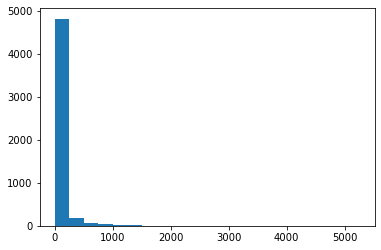

In [622]:
import matplotlib.pyplot as plt

bins = np.arange(frequencies[1].min(), frequencies[1].max()+1, 250)
print(bins)
plt.hist(frequencies[1], bins=bins)


### Compute Features

1. KLD

In [623]:
# calculate the kl divergence
# https://machinelearningmastery.com/divergence-between-probability-distributions/
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.rel_entr.html
from scipy.special import rel_entr

kld = df.apply(lambda x: rel_entr(tfidf.transform(cv.transform([x.unknown])).toarray(), 
                    tfidf.transform(cv.transform([x.known])).toarray()).sum(axis=1)[0], axis=1)

In [624]:
for i in range (df.shape[0]):
    x = df.loc[i]
    print(x.unknown[:10])
    print(x.known[:10])
    tfidf_u = tfidf.transform(cv.transform([x.unknown])).toarray()
    tfidf_k = tfidf.transform(cv.transform([x.known])).toarray()
    e = rel_entr(tfidf_u, tfidf_k).sum(axis=1)[0]
    print(tfidf_u)

Oh, he's c
My, my, I 
[[0. 0. 0. ... 0. 0. 0.]]
But speed 
Sir, you a
[[0. 0. 0. ... 0. 0. 0.]]
But the gr
God!  What
[[0. 0. 0. ... 0. 0. 0.]]
It turns t
Sullen nig
[[0. 0. 0. ... 0. 0. 0.]]
Who'll it 
Gimme a sh
[[0. 0. 0. ... 0. 0. 0.]]
I agree. P
After that
[[0. 0. 0. ... 0. 0. 0.]]
Whoa, ther
Hurrah, hu
[[0. 0. 0. ... 0. 0. 0.]]
Nora Eudor
Don't brin
[[0. 0. 0. ... 0. 0. 0.]]
Won't it b
And say, "
[[0. 0. 0. ... 0. 0. 0.]]
Oh, come o
Instead of
[[0. 0. 0. ... 0. 0. 0.]]
Come and s
Not for mi
[[0. 0. 0. ... 0. 0. 0.]]
No--of cou
Aw, goin' 
[[0. 0. 0. ... 0. 0. 0.]]
In serving
Bow impres
[[0. 0. 0. ... 0. 0. 0.]]
I forget n
In short, 
[[0.         0.         0.         ... 0.03461933 0.         0.        ]]
Ay know it
And now to
[[0. 0. 0. ... 0. 0. 0.]]
That's bec
Whoa, ther
[[0.06639609 0.         0.         ... 0.         0.         0.        ]]
Well, I ha
It's a won
[[0. 0. 0. ... 0. 0. 0.]]
Lads like 
Oh, 'tis y
[[0. 0. 0. ... 0. 0. 0.]]
Oh, for he
Oh, 'tis y
[[0.03046537 0.   

In [625]:
np.unique(kld)

array([inf])

2. Cosin Similarity

In [626]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html
from sklearn.metrics.pairwise import cosine_similarity

coss_tf = cosine_similarity(cv.transform(df.unknown), cv.transform(df.known))
coss_tfidf = cosine_similarity(tfidf.transform(cv.transform(df.unknown)), tfidf.transform(cv.transform(df.known)))


3. Jaccard Similarity

In [627]:
from sklearn.metrics import jaccard_score

jaccards = []

for i in range (df.shape[0]):
    x = df.loc[i]
    u = cv.transform([x.unknown]).toarray()[0]
    k = cv.transform([x.known]).toarray()[0]
    jaccards.append(jaccard_score(u, k, average='weighted'))
print(min(jaccards), max(jaccards))

0.6297830034090023 0.757777733783381


In [628]:
def get_jaccards(i) :
    return jaccard_score(cv.transform([x.unknown]).toarray()[0], 
            cv.transform([x.known]).toarray()[0], 
            average='weighted')

In [629]:
type(kld)

pandas.core.series.Series

In [630]:
df = df.assign(tf = lambda x: coss_tf[x.index, x.index],
    tfidf = lambda x: coss_tfidf[x.index, x.index], 
    kld = kld,
    jaccard = lambda x: get_jaccards(x.index)
    ).sort_values(by='tf', ascending=False)
df

,id,unknown,known,truth,tf,tfidf,kld,jaccard
64,EN065,"You mutt, you! I've stood enough from you. Don...","I can't, Annie. Why can't you? A woman couldn'...",Y,0.783151,0.632436,inf,0.684891
68,EN069,Mush! Indade and I will ask your pardon a tho...,"I can't, Annie. Why can't you? A woman couldn'...",Y,0.761971,0.616128,inf,0.684891
52,EN053,"God blast it! No, your kind never realises thi...","Don't be standin' there like a hawk, Harpooner...",Y,0.758615,0.592036,inf,0.684891
38,EN039,"Oh, 'tis you, is it? What're ye shiverin' 'bou...","Yes--we'll wait--certainly, we're all right. I...",Y,0.757663,0.614462,inf,0.684891
77,EN078,Attacking across open ground: four machine bul...,It's a wonder you wouldn't stop this machine g...,N,0.752491,0.581200,inf,0.684891
...,...,...,...,...,...,...,...,...
67,EN068,"Things are seldom what they seem, Skim milk ma...","Serve ye right, ye old divil--havin' a woman a...",N,0.467509,0.249663,inf,0.684891
7,EN008,"Nora Eudora, darlin', have ye got a sofy pillo...",Don't bring Hannibal in till I know where she'...,N,0.463103,0.266603,inf,0.684891
8,EN009,Won't it be a pretty wedding? Will not Lisa lo...,"And say, ""How clever!"" At whatsoever She conde...",Y,0.458969,0.292534,inf,0.684891
49,EN050,Dogs take to her. That's a sure sign. Little ...,Mr Foreson? Sir? We'll do that lighting again....,Y,0.453025,0.244304,inf,0.684891


### Training

In [631]:
X = df[['tf', 'tfidf', 'jaccard']]
y = df['truth']

In [632]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)


In [633]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [634]:
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from sklearn.naive_bayes import MultinomialNB
gnb = MultinomialNB()
# gnb.fit(X, y)
gnb.fit(X_train, y_train)


clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
# clf.fit(X, y)
clf.fit(X_train, y_train)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [635]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X_test, y_test, cv=5, scoring='f1_macro')
scores2 = cross_val_score(gnb, X_test, y_test, cv=5, scoring='f1_macro')
# print(scores)
# print(scores2)

In [636]:
np.average(scores), np.average(scores2)


(0.39999999999999997, 0.3333333333333333)

In [639]:
predicted = clf.predict(X_test)

In [640]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predicted, target_names=np.unique(y_train)))

              precision    recall  f1-score   support

           N       0.58      0.70      0.64        10
           Y       0.62      0.50      0.56        10

    accuracy                           0.60        20
   macro avg       0.60      0.60      0.60        20
weighted avg       0.60      0.60      0.60        20



### Testing

In [535]:
raw_test = [] 

test_foldername = 'authorship-verification/test'
test_folders = [f for f in listdir(test_foldername)]
for f in sorted(test_folders):
    file_dir = test_foldername+'/'+f
    if isdir(file_dir):
        file_path = test_foldername+'/'+f

        unknown = pd.read_csv(file_path+'/'+'unknown.txt', sep="delimiter", header=None, engine='python')[0].str.cat(sep=' ')
        known = pd.read_csv(file_path+'/'+'known01.txt', sep="delimiter", header=None, engine='python')[0].str.cat(sep=' ')

        df = {
            'id': f,
            'unknown' : unknown.replace('_', ''),
            'known' : known.replace('_', '')
        }
        raw_test.append(df)

In [536]:
df_test=pd.DataFrame(raw_test)
df_test

,id,unknown,known
0,EN001,Is he now? The late Mr. Mulligan was niver muc...,"Oh, if you only would. I'd just love to have a..."
1,EN002,"Then I run, and I run, and I run, till I was b...","you walking into my big, empty halls. I've ma..."
2,EN003,"But, bless my heart, consider my position! I a...","Tomorrow comes the great, grand festival of Ch..."
3,EN004,Is he now? The late Mr. Mulligan was niver muc...,Then you think the sea's to blame for everythi...
4,EN005,And ye're aven makin' a bit of an iliphant for...,"Yes, Tomasso, tell us the secret; we'll never ..."
...,...,...,...
495,EN496,"Plenty of children there are in our city, Who ...","Hurry, Jack, and fill up the shoes and stockin..."
496,EN497,He's a hog on two legs. You bet! I hope to get...,Naisi and his brothers are well pleased with t...
497,EN498,"It is not, stranger, but she won't be coming n...","Here's health, then, to herself and you! Here'..."
498,EN499,"Good evening to you, lady of the house. Good ...","you walking into my big, empty halls. I've ma..."


In [537]:
coss_tf_test = cosine_similarity(cv.transform(df_test.unknown), cv.transform(df_test.known))
coss_tfidf_test = cosine_similarity(tfidf.transform(cv.transform(df_test.unknown)), tfidf.transform(cv.transform(df_test.known)))


In [538]:
df_test = df_test.assign(tf = lambda x: coss_tf_test[x.index, x.index],
    tfidf = lambda x: coss_tfidf_test[x.index, x.index], 
    jaccard = lambda x: get_jaccards(x.index)
    )
df_test

,id,unknown,known,tf,tfidf,jaccard
0,EN001,Is he now? The late Mr. Mulligan was niver muc...,"Oh, if you only would. I'd just love to have a...",0.544075,0.386073,0.684891
1,EN002,"Then I run, and I run, and I run, till I was b...","you walking into my big, empty halls. I've ma...",0.803642,0.646535,0.684891
2,EN003,"But, bless my heart, consider my position! I a...","Tomorrow comes the great, grand festival of Ch...",0.529254,0.336504,0.684891
3,EN004,Is he now? The late Mr. Mulligan was niver muc...,Then you think the sea's to blame for everythi...,0.496697,0.340687,0.684891
4,EN005,And ye're aven makin' a bit of an iliphant for...,"Yes, Tomasso, tell us the secret; we'll never ...",0.585020,0.408836,0.684891
...,...,...,...,...,...,...
495,EN496,"Plenty of children there are in our city, Who ...","Hurry, Jack, and fill up the shoes and stockin...",0.678176,0.460801,0.684891
496,EN497,He's a hog on two legs. You bet! I hope to get...,Naisi and his brothers are well pleased with t...,0.680616,0.515015,0.684891
497,EN498,"It is not, stranger, but she won't be coming n...","Here's health, then, to herself and you! Here'...",0.823788,0.682480,0.684891
498,EN499,"Good evening to you, lady of the house. Good ...","you walking into my big, empty halls. I've ma...",0.784300,0.642753,0.684891


In [539]:
X = df_test[['tf', 'tfidf', 'jaccard']]
X_scaled = min_max_scaler.transform(X)
predicted = clf.predict(X_scaled)

In [540]:
pd.DataFrame(predicted).value_counts()

Y    388
N    112
dtype: int64

In [546]:
df_result = df_test['id']+ " " +np.array(predicted)
df_result

0      EN001 N
1      EN002 Y
2      EN003 N
3      EN004 N
4      EN005 Y
        ...   
495    EN496 Y
496    EN497 N
497    EN498 Y
498    EN499 Y
499    EN500 Y
Name: id, Length: 500, dtype: object

In [549]:
# df_result.to_csv("result.txt", sep='\n', index=False, header=False)

Failed: Probability Distribution

In [237]:
from nltk.probability import FreqDist, DictionaryProbDist
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

In [238]:
s = ' '.join(df['unknown'].astype(str).str.lower() +
            df['known'].astype(str).str.lower())

In [239]:
t = word_tokenize(s)
t = [''.join(token) for token in list(ngrams(s, 3))] 
# FreqDist(t).freq('the')
# freqdist =  FreqDist(t)
freqdist = FreqDist(t)
probdist = DictionaryProbDist(freqdist, normalize=True)


In [240]:
frequencies[frequencies[0].str.contains('oh,')]

,0,1
3456,"oh,",213


In [241]:
[''.join(tt) for tt in t]

['you',
 'ou ',
 'u m',
 ' mu',
 'mut',
 'utt',
 'tt,',
 't, ',
 ', y',
 ' yo',
 'you',
 'ou!',
 'u! ',
 '! i',
 " i'",
 "i'v",
 "'ve",
 've ',
 'e s',
 ' st',
 'sto',
 'too',
 'ood',
 'od ',
 'd e',
 ' en',
 'eno',
 'nou',
 'oug',
 'ugh',
 'gh ',
 'h f',
 ' fr',
 'fro',
 'rom',
 'om ',
 'm y',
 ' yo',
 'you',
 'ou.',
 'u. ',
 '. d',
 ' do',
 'don',
 "on'",
 "n't",
 "'t ",
 't y',
 ' yo',
 'you',
 'ou ',
 'u d',
 ' da',
 'dar',
 'are',
 're.',
 'e. ',
 '. l',
 ' lo',
 'lov',
 'ove',
 've ',
 "e '",
 " 'e",
 "'em",
 'em!',
 'm! ',
 '! o',
 ' oh',
 'oh,',
 'h, ',
 ', m',
 ' my',
 'my ',
 'y g',
 ' ga',
 'gaw',
 'awd',
 'wd!',
 'd! ',
 '! y',
 ' yo',
 'you',
 'ou ',
 'u d',
 ' da',
 'dam',
 'amn',
 'mn ',
 'n t',
 ' th',
 'thi',
 'hic',
 'ick',
 'ck-',
 'k-h',
 '-he',
 'hea',
 'ead',
 'ad!',
 'd! ',
 '! l',
 ' lo',
 'lov',
 'ove',
 've ',
 "e '",
 " 'e",
 "'em",
 'em?',
 'm? ',
 '? i',
 ' i ',
 'i h',
 ' ha',
 'hat',
 'ate',
 'ted',
 'ed ',
 "d '",
 " 'e",
 "'em",
 'em,',
 'm, ',
 ', i',


In [242]:
probdist._prob_dict
probdist.prob('oh,')

0.0005936024702780735

In [243]:
type(df.known.values[0])

str

In [244]:
# total = count_list.sum()
# prob = [x / total for x in cv.transform([df.known.values[0]]).toarray()]
# np.sum(prob)

In [245]:
# cv.inverse_transform(cv.transform([df.known.values[0]]))

In [246]:
pd.DataFrame([cv.vocabulary_])

,"oh,","h,",", h",he,he',e's,'s,s c,co,com,...,eds,sau,auc,ucy,im;,bug,--k,a-b,opm,r -
0,3456,2166,443,122,2196,1560,400,4114,74,1306,...,1635,4177,1031,4638,2450,1182,508,793,3556,3819


In [247]:
count1 = 0
count2 = 0
for k in probdist._prob_dict.keys():
    if k not in cv.vocabulary_.keys():
        count1+=1

for k in cv.vocabulary_.keys():
    if k not in probdist._prob_dict.keys():
        count2+=1

print(count1, count2)


843 4


In [248]:
len(t) != len(set(t))

True

In [249]:
probdist_df = pd.DataFrame([probdist._prob_dict])
probdist_df

,you,ou,u m,mu,mut,utt,"tt,","t,",", y",yo,...,ao.,nvo,ri;,lta,we!,r!-,ue-,me:,r'-,"dd,"
0,0.007391,0.003941,0.000217,0.000694,0.000053,0.000159,0.000006,0.001184,0.000541,0.007201,...,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000006,0.000006,0.000003,0.000003


In [250]:
df.loc[0].unknown

"Oh, he's coming, he's coming. I'm going to get to see Santa Claus! Is it not wonderful? I'm going to see him. Let me look.  Oh, it's getting bigger and bigger and BIGGER! Hurray! daddy's coming! daddy's coming! Now I can hear the bells. Oh, it's coming closer and closer and CLOSER. Look out, it's going to hit the boat! He flew right by us. Maybe he didn't see the boat. Oh, now he isn't coming at all. Yes, he is. He's landed right over there. Here he comes; here he comes! Here we are, Santa Claus. This is the place. Come in. Merry Christmas, Santa Claus, merry Christmas! Hello, there--where are you? It's so dark I can't see a single thing. Hello, daddy; merry Christmas. Hello yourself. Merry Christmas to you, too. Are you all ready for me? Yes, it's all ready. The magical tree is just waiting for your touch to turn into a real Christmas tree. Oh, we're going to have a real Christmas tree. Hello, who's this young person? This is Anita. And why isn't she sound asleep like the rest of the

In [251]:
tokenized = pd.DataFrame(cv.transform([df.loc[0].unknown]).toarray(), columns=cv.get_feature_names_out()).sort_values(by=0, axis=1, ascending=False)
tokenized

,th,and,nd,an,he,the,he,ing,'s,to,...,eyo,ey?,exe,ey.,ey-,"ey,",ext,exp,exi,èd
0,27,24,22,22,22,21,18,14,14,13,...,0,0,0,0,0,0,0,0,0,0


In [252]:
probdist_df[tokenized > 0].sort_values(by=0, axis=1, ascending=False).fillna(0)

,th,the,he,you,yo,an,nd,and,to,ing,...,ao.,nvo,ri;,lta,we!,r!-,ue-,me:,r'-,"dd,"
0,0.014667,0.011265,0.008726,0.007391,0.007201,0.006633,0.006513,0.006371,0.00576,0.005016,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [253]:
def kl_divergence(a, b):
    return sum(a[i] * np.log(a[i]/b[i]) for i in range(len(a)))

In [254]:
count = 0
epsilon = np.finfo('float').eps

for i in range (df.shape[0]):
    x = df.loc[i]
    u = pd.DataFrame(cv.transform([df.loc[0].unknown]).toarray(), columns=cv.get_feature_names_out())
    k = pd.DataFrame(cv.transform([df.loc[0].known]).toarray(), columns=cv.get_feature_names_out())
    prob_u = probdist_df[u > 0].fillna(epsilon).values
    prob_k = probdist_df[k > 0].fillna(epsilon).values
    # print(probdist_df[u > 0].isna())
    # e = rel_entr(prob_u, prob_k).sum(axis=1)[0]

    e = rel_entr(prob_u, prob_k).sum(axis=1)[0]
    kl = kl_divergence(prob_u, prob_k)
    count+=1
    print(e)
    print(kl)
print(count)

3.8328144838715423
[0. 0. 0. ... 0. 0. 0.]
3.8328144838715423
[0. 0. 0. ... 0. 0. 0.]
3.8328144838715423
[0. 0. 0. ... 0. 0. 0.]
3.8328144838715423
[0. 0. 0. ... 0. 0. 0.]
3.8328144838715423
[0. 0. 0. ... 0. 0. 0.]
3.8328144838715423
[0. 0. 0. ... 0. 0. 0.]
3.8328144838715423
[0. 0. 0. ... 0. 0. 0.]
3.8328144838715423
[0. 0. 0. ... 0. 0. 0.]
3.8328144838715423
[0. 0. 0. ... 0. 0. 0.]
3.8328144838715423
[0. 0. 0. ... 0. 0. 0.]
3.8328144838715423
[0. 0. 0. ... 0. 0. 0.]
3.8328144838715423
[0. 0. 0. ... 0. 0. 0.]
3.8328144838715423
[0. 0. 0. ... 0. 0. 0.]
3.8328144838715423
[0. 0. 0. ... 0. 0. 0.]
3.8328144838715423
[0. 0. 0. ... 0. 0. 0.]
3.8328144838715423
[0. 0. 0. ... 0. 0. 0.]
3.8328144838715423
[0. 0. 0. ... 0. 0. 0.]
3.8328144838715423
[0. 0. 0. ... 0. 0. 0.]
3.8328144838715423
[0. 0. 0. ... 0. 0. 0.]
3.8328144838715423
[0. 0. 0. ... 0. 0. 0.]
3.8328144838715423
[0. 0. 0. ... 0. 0. 0.]
3.8328144838715423
[0. 0. 0. ... 0. 0. 0.]
3.8328144838715423
[0. 0. 0. ... 0. 0. 0.]
3.832814483

KeyboardInterrupt: 

In [ ]:
df

,id,unknown,known,truth
0,EN001,"Oh, he's coming, he's coming. I'm going to get...","My, my, I was forgetting all about the childre...",Y
1,EN002,"But speed thy steps, the cold will work thee i...","Sir, you are sad! The silent eloquence Of yond...",N
2,EN003,But the grub's gittin' low. They's enough to l...,God! What beauty! Umm? I said: God! What bea...,N
3,EN004,"It turns the night to day, it shines so bright...",Sullen night is laughing day-- All the year is...,N
4,EN005,"Who'll it be? Ah, it's Fred Nicholls, maybe. E...",Gimme a shock. Number Two. Same here. Here's l...,Y
...,...,...,...,...
95,EN096,"If 'e keeps quiet, I won't. But I'm not accou...","He's fur me. Scwumptious! Maw, they had a show...",N
96,EN097,"And O my darling, O my pet, Whatever else you ...","In short, if you'd kindle The spark of a swind...",Y
97,EN098,There you go kiddin' again. But you was going ...,"And if I get in my baby buggy, I'll bweak it a...",N
98,EN099,"Of life, alas! his leave he's taking, For ah! ...","You mutt, you! I've stood enough from you. Don...",N
